In [14]:
# !pip install scikit-learn
# !pip install pandas
# !pip install pytorch-lightning
# !pip install numpy
# !pip install torch
# !pip install logomaker
# !pip install captum

In [15]:
# load model from ckpt
import torch
import pandas as pd
from model import onehot_encode, LightningModule, pad_sequences
import numpy as np
import logomaker
from matplotlib import pyplot as plt
from captum.attr import DeepLiftShap

In [16]:
# USER INPUTS
model_paths = ['saved_models/model_oldPp_fc1.ckpt']
# model_paths = ['saved_models/model_2023_fc1.ckpt']
# model_paths = ['saved_models/model_old_naive.ckpt']

csv_path = 'test.csv'

In [17]:

models = []
for model_path in model_paths:
    loaded_model = LightningModule.load_from_checkpoint(model_path, strict=False)
    loaded_model.eval()
    models.append(loaded_model)

test_data = pd.read_csv(csv_path)

# group by 512 for the predictions
all_ids, all_seqs = [], []
for i in range(0, len(test_data), 512):
    all_ids.append(test_data['ID'][i:i+512])
    all_seqs.append(
        pad_sequences(
            [onehot_encode(seq) for seq in test_data['SEQ'][i:i+512]], 0
        )
    )

# Generate predictions

In [18]:
for batch_ids, batch_seqs in zip(all_ids, all_seqs):
    preds = []
    for model in models:
        X = torch.from_numpy(batch_seqs).float().to(model.device)
        predictions = model(X).sigmoid()
        preds.append(predictions)

    # take average
    preds = torch.stack(preds)
    avg_preds = torch.mean(preds, dim=0)

    for id_, pred in zip(batch_ids, avg_preds):
        print(id_, f'{pred.item():.3f}', sep=',')

seq1,0.197
seq2,0.188


In [19]:
lengths = torch.tensor([20,9])
# create mask from lengths
max_len = lengths.max()
mask = torch.arange(max_len).expand(len(lengths), max_len) < lengths.unsqueeze(1)

# Convert the boolean mask to float (if needed for operations like masking input)
mask = mask.float()


# Generate saliency maps (note that results are without normalization)

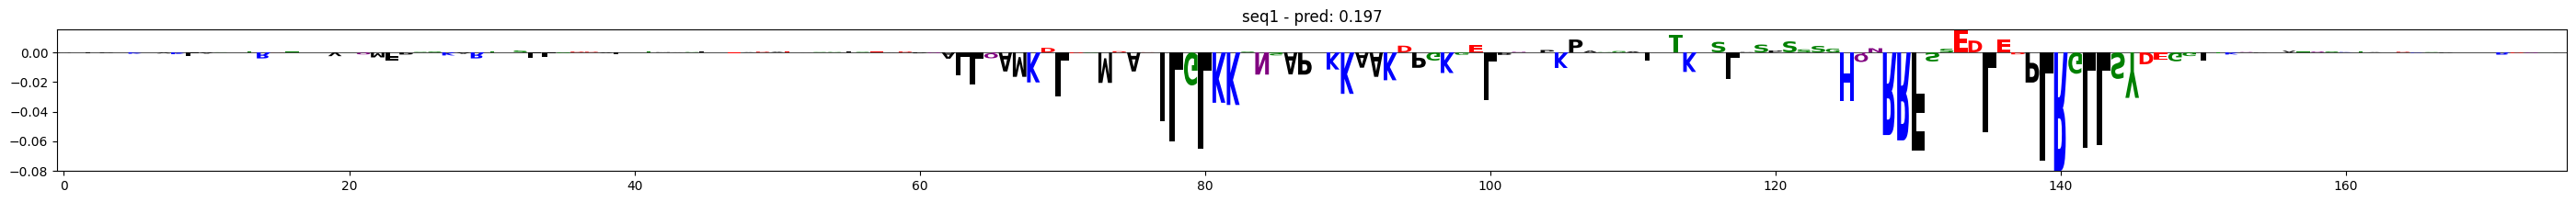

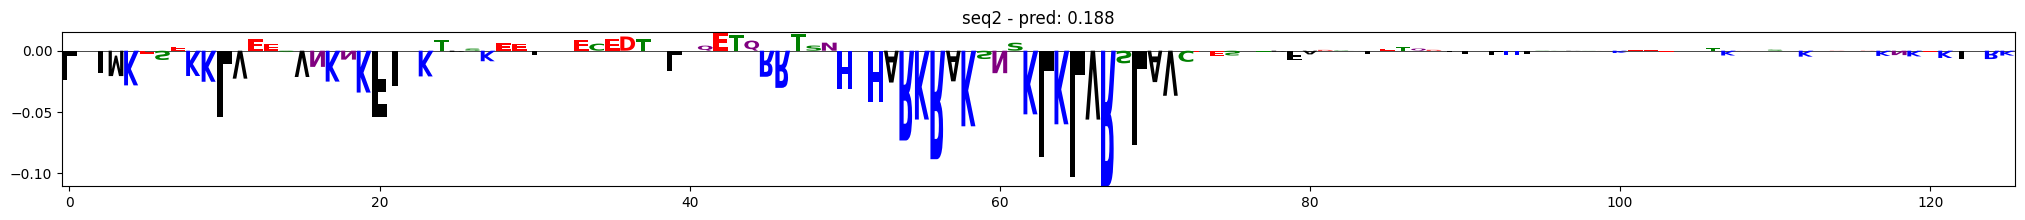

In [21]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

num_shuffles = 10
for id_, seq in zip(test_data['ID'], test_data['SEQ']):
    attributions = []
    predictions = []
    for model in models:
        X = onehot_encode(seq)
        shap = DeepLiftShap(model, multiply_by_inputs=True)
        X = torch.from_numpy(X).unsqueeze(0).float().to(model.device)
        predictions.append(model(X).sigmoid().item())
        baseline = X.repeat(num_shuffles, 1, 1)
        shuffle_indices = torch.randperm(X.shape[1])
        baseline = baseline[:, shuffle_indices, :]
        shap_values, delta = shap.attribute(X, target=0, baselines=baseline, return_convergence_delta=True)
        shap_values = shap_values * X
        shap_values = shap_values.detach().cpu().numpy()
        attributions.append(shap_values)
    attributions = np.mean(attributions, axis=0).squeeze()
    avg_pred = np.mean(predictions)
    
    df = pd.DataFrame(attributions, columns=list('_ACDEFGHIKLMNPQRSTVWY'), dtype=float)
    df.drop(columns='_', inplace=True)
    plt.figure(figsize=(len(seq)/5, 2))
    logomaker.Logo(df, color_scheme='chemistry', ax=plt.gca())
    plt.title(f'{id_} - pred: {avg_pred:.3f}')

        